In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt
import getfem as gf
import numpy as np
%pylab inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12



%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [7]:
def batch_loader(X, batch_size=3000):
    
    n_samples = X.shape[0]
    
                      
    for i in range(0, n_samples, batch_size):
            X_batch = X[i:i + batch_size]
            
            yield X_batch
    X_batch = X[n_samples-1-n_samples%batch_size:-1]
    yield X_batch

In [8]:
from torch.utils.data import DataLoader,TensorDataset
class PINN(nn.Module):
    #TODO инициализация весов
    def dudn(self, u_x, u_y, u_z):
        out = u_x
        if u_y:
            out += u_y
        if u_z:
            out+=u_z

    def K(self, u):
        return torch.full_like(u,1) + 0.5*u

    def __init__(self,u0:float,pc, ds,t,x,y=None,z=None):
        super(PINN,self).__init__()
        self.u0 = u0
        self.pc = pc
        self.t = t
        self.x = x
        self.y = y
        self.z = z
        self.X = torch.concat([t.view(-1,1),x.view(-1,1)],dim=1)
        self.dims = 1
        if y:
            self.dims+=1
            self.X = torch.concat([self.X,y.view(-1,1)],dim=1)
            
        if z:
            self.dims+=1
            self.X = torch.concat([self.X,z.view(-1,1)],dim=1)
        
        
        self.linear1 = nn.Linear(self.dims+1,ds)
        self.linear2 = nn.Linear(ds,ds)
        self.linear3 = nn.Linear(ds,ds//2)
        
        self.linear_out = nn.Linear(ds//2,1)


        self.Adam = torch.optim.Adam(self.parameters())
        self.LBFGS = torch.optim.LBFGS(self.parameters(), lr=0.01, max_iter=200, history_size=100)
        self.MAE = nn.L1Loss()
        self.MSE = nn.MSELoss(reduction='sum')
    
        #print(self.X)
    
    def forward(self, t, x, y=None,z=None):
        input = [t.view(-1,1), x.view(-1,1)]
        if y:
            input.append(y.view(-1,1))
        if z:
            input.append(z.view(-1,1))
        X = torch.concat(input, axis = 1)
        
        l1 = torch.sin(self.linear1(X))
        
        l2 = torch.sin(self.linear2(l1))
        l3 = torch.sin(self.linear3(l2))
        


        l_out = (self.linear_out(l3))
        
        return l_out
    def closure(self,):
                t = self.X_batched[:,0:1]
                x = self.X_batched[:,1:2]
                if self.y or self.z:
                    y = self.X_batched[:,2:3]
                else:
                    y = None
                if self.z and self.y:
                    z = self.X_batched[:,3:4]
                else:
                    z = None

                
                u = self.forward(t, x, y, z)
                
                u_t = torch.autograd.grad(u,t,grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
                
                u_x = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
                u_xx = torch.autograd.grad(u_x,x,grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
                #TODO сделать нормальную проверку
                if self.y:
                    u_y = torch.autograd.grad(u,y,grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
                    u_yy = torch.autograd.grad(u_y,y,grad_outputs=torch.ones_like(u_y), create_graph=True, retain_graph=True)[0]
                else:
                    u_y = None
                if self.z:
                    u_z = torch.autograd.grad(u,z,grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
                    u_zz = torch.autograd.grad(u_z,z,grad_outputs=torch.ones_like(u_z), create_graph=True, retain_graph=True)[0]
                else:
                    u_y = None
                    
                u0_pred = self.forward(torch.zeros_like(x), x, y, z)
                self.loss_0 =  self.MSE(u0_pred , torch.full_like(u0_pred,self.u0))
                K = self.K(u)
                K_u = torch.autograd.grad(K,u,grad_outputs=torch.ones_like(K), allow_unused=True,create_graph=True, retain_graph=True)[0]
                f = self.pc(u)*u_t - K*(u_xx)
                #TODO сделать нормальную check
                if torch.is_tensor(K_u):
                    f -= K_u*u_x**2
                if self.y:
                    f -= K*u_yy 
                    if torch.is_tensor(K_u):
                        f -= K_u*u_y**2
                if self.z:
                    f -= K*u_zz
                    if torch.is_tensor(K_u):
                        f -= K_u*u_z**2
                
                #TODO сделать для 3 мерной задачи
                #TODO для различных гран условий



                #########Граничные условия##############
                x_min = torch.full_like(t[t!=0],torch.min(x).item()).requires_grad_(True)
                x_max = torch.full_like(t[t!=0], torch.max(x).item()).requires_grad_(True)
                fwd_min = self.forward(t[t!=0],x_min,y,z)
                fwd_max = self.forward(t[t!=0],x_max,y,z)
                K_max = self.K(fwd_max)
                K_min = self.K(fwd_min)
                
                dudn_min  =torch.autograd.grad(fwd_min,x_min, grad_outputs=torch.ones_like(fwd_min),create_graph=True, retain_graph=True)[0]
                
                dudn_max  =torch.autograd.grad(fwd_max,x_max, grad_outputs=torch.ones_like(fwd_max),create_graph=True, retain_graph=True)[0]
                self.loss_b = self.MSE(-K_max*dudn_max.view(-1,1),torch.zeros_like(dudn_max.view(-1,1))) + self.MSE(-K_min*dudn_min.view(-1,1), torch.ones_like(dudn_min.view(-1,1)))
                ##############################################
                

                
                self.loss_f = self.MSE(f, torch.zeros_like(f))
                self.LBFGS.zero_grad()
                self.full_loss = self.loss_f + self.loss_0 + self.loss_b
                self.full_loss.backward()

                return self.full_loss
    def LBFGS_train(self, epochs=1000):
        
        for i in range(int(epochs)):
            for X in batch_loader(self.X):
                self.X_batched = X
                self.LBFGS.step(self.closure)
            if i%10==0:
                #print(u0_pred)
                print(i, (self.loss_0).item(), self.loss_f.item() , (self.loss_b).item(), "LBFGS")


    def ADAM_train(self,epochs = 1000):
        if self.x.grad:
            self.x.grad.zero_()
        if self.t.grad:
            self.t.grad.zero_()
        for i in range(int(epochs)):
        
            for X in batch_loader(self.X):
                t = X[:,0:1]
                x = X[:,1:2]
                if self.y or self.z:
                    y = X[:,2:3]
                else:
                    y = None
                if self.z and self.y:
                    z = X[:,3:4]
                else:
                    z = None

                
                u = self.forward(t, x, y, z)
                
                u_t = torch.autograd.grad(u,t,grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
                
                u_x = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
                u_xx = torch.autograd.grad(u_x,x,grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
                #TODO сделать нормальную проверку
                if self.y:
                    u_y = torch.autograd.grad(u,y,grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
                    u_yy = torch.autograd.grad(u_y,y,grad_outputs=torch.ones_like(u_y), create_graph=True, retain_graph=True)[0]
                else:
                    u_y = None
                if self.z:
                    u_z = torch.autograd.grad(u,z,grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
                    u_zz = torch.autograd.grad(u_z,z,grad_outputs=torch.ones_like(u_z), create_graph=True, retain_graph=True)[0]
                else:
                    u_y = None
                    
                u0_pred = self.forward(torch.zeros_like(x), x, y, z)
                self.loss_0 =  self.MSE(u0_pred , torch.full_like(u0_pred,self.u0))
                K = self.K(u)
                K_u = torch.autograd.grad(K,u,grad_outputs=torch.ones_like(K), allow_unused=True,create_graph=True, retain_graph=True)[0]
                f = self.pc(u)*u_t - K*(u_xx)
                #TODO сделать нормальную check
                if torch.is_tensor(K_u):
                    f -= K_u*u_x**2
                if self.y:
                    f -= K*u_yy 
                    if torch.is_tensor(K_u):
                        f -= K_u*u_y**2
                if self.z:
                    f -= K*u_zz
                    if torch.is_tensor(K_u):
                        f -= K_u*u_z**2
                
                #TODO сделать для 3 мерной задачи
                #TODO для различных гран условий



                #########Граничные условия##############
                x_min = torch.full_like(t[t!=0],torch.min(x).item()).requires_grad_(True)
                x_max = torch.full_like(t[t!=0], torch.max(x).item()).requires_grad_(True)
                fwd_min = self.forward(t[t!=0],x_min,y,z)
                fwd_max = self.forward(t[t!=0],x_max,y,z)
                K_max = self.K(fwd_max)
                K_min = self.K(fwd_min)
                
                dudn_min  =torch.autograd.grad(fwd_min,x_min, grad_outputs=torch.ones_like(fwd_min),create_graph=True, retain_graph=True)[0]
                
                dudn_max  =torch.autograd.grad(fwd_max,x_max, grad_outputs=torch.ones_like(fwd_max),create_graph=True, retain_graph=True)[0]
                self.loss_b = self.MSE(-K_max*dudn_max.view(-1,1),torch.zeros_like(dudn_max.view(-1,1))) + self.MSE(-K_min*dudn_min.view(-1,1), torch.ones_like(dudn_min.view(-1,1)))
                ##############################################
                

                
                self.loss_f = self.MSE(f, torch.zeros_like(f))
                self.Adam.zero_grad()
                (self.loss_f + self.loss_0 + self.loss_b).backward()

                self.Adam.step()

            if i%100==0:
                #print(u0_pred)
                
                print(i, (self.loss_0).item(), self.loss_f.item() , (self.loss_b).item())
        
                
            

        
        



        






        
        



In [9]:
h = 0.1
L = 3
tau  =0.1
T = 10
x = np.linspace(0,L, int(L/h)+1)
t = np.linspace(0,T,int((T)/tau)+1)
pc = lambda x: 1 + 0.5*x

In [10]:

xx,tt = np.meshgrid(x,t)

x = torch.from_numpy(xx.reshape(-1,1)).to(torch.float32)
t = torch.from_numpy(tt.reshape(-1,1)).to(torch.float32)

x.requires_grad_(True)
t.requires_grad_(True)

p = PINN(0,pc,100,t,x)

p.ADAM_train(epochs=4000)
p.LBFGS_train(epochs = 20)




0 0.5588972568511963 0.3099820613861084 120.08937072753906
100 0.2607598900794983 0.06894391030073166 0.05585094541311264
200 0.19753919541835785 0.05261935666203499 0.023850085213780403
300 0.14743205904960632 0.04988899081945419 0.020825659856200218
400 0.11265140771865845 0.037220463156700134 0.009275193326175213
500 0.11339391022920609 0.03504376485943794 0.10555399954319
600 0.15264201164245605 0.06099516153335571 0.1509658247232437
700 0.05957748740911484 0.02555021084845066 0.009297643788158894
800 0.050826918333768845 0.025437185540795326 0.009726138785481453
900 0.04250703006982803 0.017824679613113403 0.007535766810178757
1000 0.035831011831760406 0.014785411767661572 0.005870611406862736
1100 0.031054768711328506 0.011792234145104885 0.004999713972210884
1200 0.028637509793043137 0.016628770157694817 0.009126976132392883
1300 0.022478146478533745 0.009119292721152306 0.004924342036247253
1400 0.019657541066408157 0.00634229090064764 0.003427893854677677
1500 0.01717408746480

In [11]:
def solution(x,t,L,n_max):
    V = t/L + L/3
    for n in range(1,n_max+1):
        V+=-2*L/(math.pi**2*n**2)*torch.exp(-math.pi**2*n**2*t/L**2)*torch.cos(math.pi*n*x/L)
    return -2 + 2*torch.sqrt(-x + x**2/(2*L) + 1 + V)


0.0022024495992809534 0.003185292473062873 0.00027696145116351545
tensor([[0.0119]])


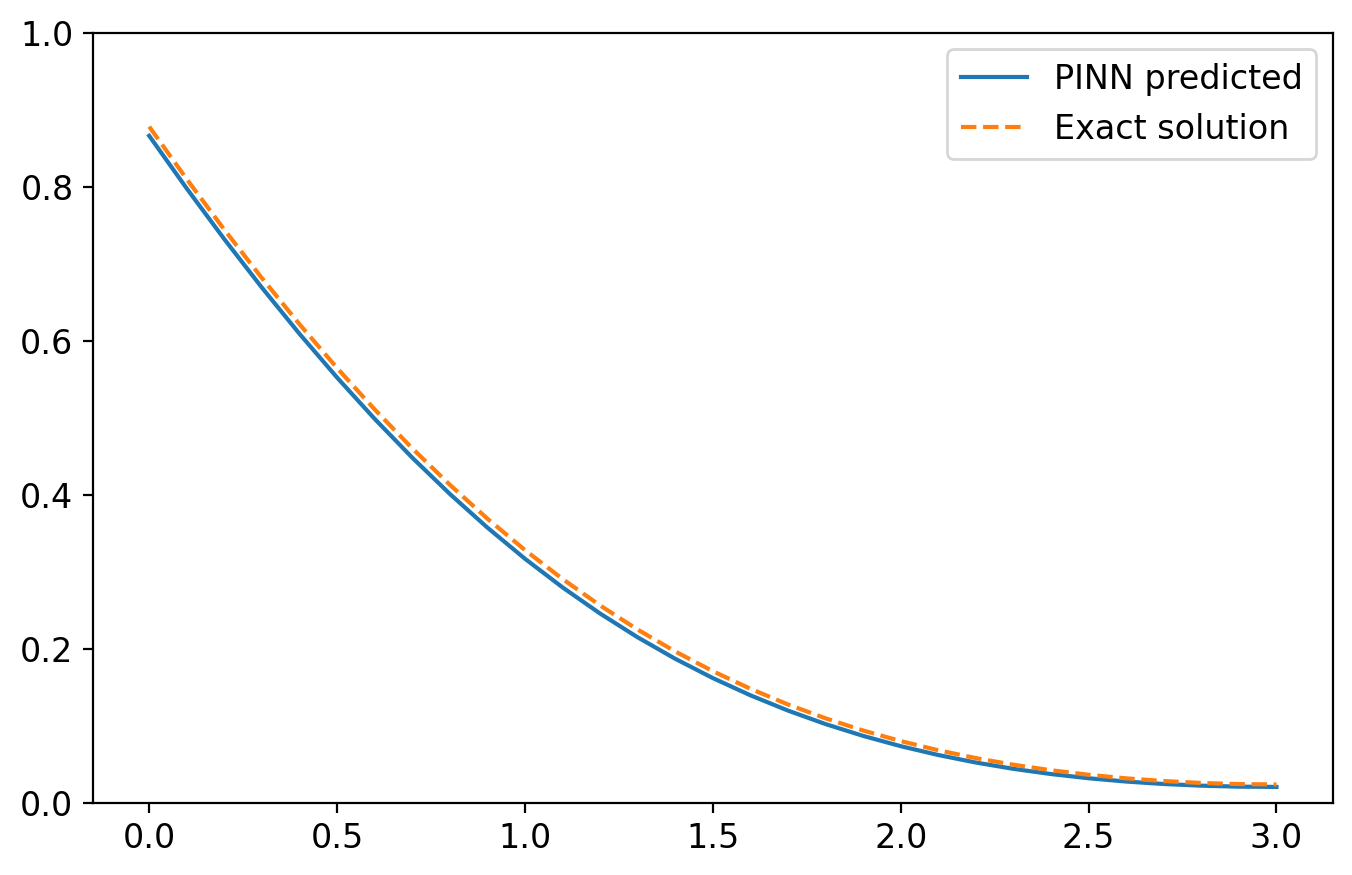

In [22]:
print(p.loss_0.item(), p.loss_f.item(),p.loss_b.item())

t = torch.from_numpy(tt[0]).to(torch.float32)
x = torch.from_numpy(xx[0]).to(torch.float32)
u = []
t = 0.9*torch.ones_like(x)
for xi,ti in zip(x,t):
    u.append(p.forward(ti,xi).detach())

plt.plot(x.detach(),u,label='PINN predicted')
u0pinn = (u[0])
u = solution(x,t,L,1000)
u0exact = (u[0])
print(torch.abs(u0exact) - torch.abs(u0pinn))
plt.plot(x.detach(),u, label = 'Exact solution', linestyle = '--')
plt.ylim(0,1)
plt.legend()
